# AIFFEL 다섯 번째 프로젝트 : Spectrogram Classification 모델 구현
- 실습 : 1차원 Waveform 데이터를 통해 text 라벨 출력
    - 기본 버전 / Skip-connection 버전으로 나누어 학습
- 프로젝트 : 2차원 Spectrogram 데이터를 통한 모델 학습 > 기본/Skip-connection 버전으로 나누어 진행
- 데이터 처리/분류(waveform) > 학습 하이퍼파라미터 구성 > 데이터셋 구성 > Spectrogram 데이터 처리 모델 구성 > 학습 결과 그래프 출력 > 테스트 데이터로 모델 성능 평가
---
## 1. 데이터 처리와 분류
1. wav 데이터를 바탕으로 라벨 데이터 처리 및 spectrogram 변환
    - 라벨 데이터 : 노드의 리스트를 가져오지 않고, speech_data의 라벨 값을 가져와 진행하였다.
    - spectrogram 변환 : wav 파일이 큰 편이라 변환 시, 커널이 자꾸 죽는 경우가 발생했다. 학습 모델 두 가지 진행할 때도 종종 그래서, 커널을 모델 학습 전에 껐다 켜는 방식으로 진행했다.

In [1]:
# wave 데이터 가져오기
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)


In [2]:
# 라벨 데이터
target_list = np.unique(speech_data["label_vals"])
label_value = target_list

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

# label data를 index 작업을 통해 더 쉽게 사용할 수 있다.
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data.shape

Indexed LABEL :  {'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'silence': 7, 'stop': 8, 'unknown': 9, 'up': 10, 'yes': 11}


(50620,)

In [3]:
import librosa # FFT 관련 라이브러리

def wav2spec(wav, fft_size=258):
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

spec_data = []
for wav in speech_data["wav_vals"]:
    spec_data.append(wav2spec(wav))
spec_data = np.array(spec_data)
spec_data.shape

(50620, 130, 126)

2. 데이터 시각화
    - Spectrogram 시각화를 위해 변환한 데이터 중 하나를 읽어왔다.
    - spec_data의 y축 주파수 파악을 위해, 축 표시를 추가했다. 
        - `y_axis='linear'` : 옵션 변경으로 주파수 표시 스케일을 달리 할 수 있다.
    - 노드에서 진행한 1차원의 waveform 데이터의 샘플 데이터를 2차원 spectrogram 데이터로 변환했다. x축은 시간, y축은 주파수 축으로 구성되어 있다. 음파 강도에 따라 밝은 색으로 표현된다.

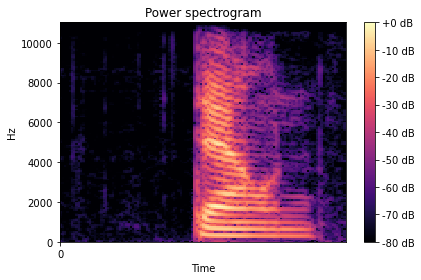

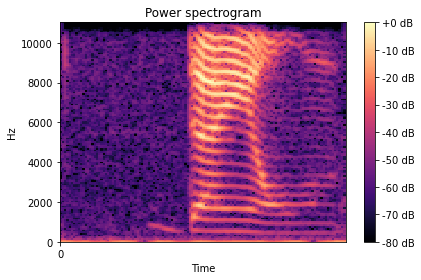

In [30]:
import librosa.display
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
librosa.display.specshow(librosa.amplitude_to_db(spec_data[0], ref=np.max), x_axis='time', y_axis='linear', ax=ax)
plt.title('Power spectrogram')
plt.colorbar(img, format='%+2.0f dB', ax=ax)
plt.xticks(range(0, 1))
plt.tight_layout()

fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(spec_data[1], ref=np.max), x_axis='time', y_axis='linear', ax=ax)
plt.title('Power spectrogram')
plt.colorbar(img, format='%+2.0f dB', ax=ax)
plt.xticks(range(0, 1))
plt.tight_layout()

- `sklearn`의 `train_test_split` 함수를 이용하여 train, test를 분리하고 reshape 하였다.
    - Conv2D 학습 모델에 spec의 차원을 맞추기 위해, reshape을 진행했다.

In [4]:
from sklearn.model_selection import train_test_split

train_spec, test_spec, train_label, test_label = train_test_split(spec_data, 
                                                                label_data, 
                                                                test_size=0.1,
                                                                random_state = 1993,
                                                                shuffle=True)
train_spec = train_spec.reshape(-1, 130, 126, 1)
test_spec = test_spec.reshape(-1, 130, 126, 1)

## 2. 학습 하이퍼 파라미터 설정

In [5]:
batch_size = 32
max_epochs = 10

## 3. 데이터셋 구성

In [6]:
# 데이터셋 구성 전 메모리 확보를 위해 사용하지 않는 데이터 삭제
del speech_data
del spec_data

In [7]:
def one_hot_label(spec, label):
    label = tf.one_hot(label, depth=12)
    return spec, label

In [8]:
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_spec, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_spec, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>


## 4. 2차원 Spectrogram 데이터를 처리하는 모델 구성
- batchnorm, dropout, dense layer 등을 이용
- 12개의 단어 class를 구분하는 loss를 사용하고 Adam optimizer를 사용
- 모델 가중치를 저장하는 checkpoint callback 함수 추가

### 4.1 기본 모델
- 노드에 있는 Conv1D 레이어를 Conv2D 레이어로 바꾸기 위한 코드를 작성했다.
- Conv2D의 두 번째 파라미터를 9에서 (3,3)으로 변경하였다.
- 2차원 spectrogram를 모델에 입력하기 위해, `layers.Input(shape=(130, 126, 1))`로 shape를 맞춰주었다.

In [9]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(130, 126, 1)) # 2차원 spectrogram 차원에 shape 맞춤

x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_basic = tf.keras.Model(input_tensor, output_tensor)

model_basic.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 126, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 130, 126, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 130, 126, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 65, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 65, 63, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 65, 63, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 31, 64)        0     

### 4.2 Skip-Connection 모델

In [9]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(130, 126, 1))

x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
skip_1 = layers.MaxPool2D()(x)

x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(skip_1)
x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1) # skip-connection
skip_2 = layers.MaxPool2D()(x)

x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(skip_2)
x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool2D()(x)

x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(skip_3)
x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_skip = tf.keras.Model(input_tensor, output_tensor)

model_skip.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 130, 126, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 130, 126, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 130, 126, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 65, 63, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

## 5. 학습 loss, accuracy 그래프 출력
### 5.1 기본 모델

In [10]:
# loss
optimizer=tf.keras.optimizers.Adam(1e-4)
model_basic.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

In [11]:
# 기본 모델의 save point (skip-connection 모델의 save point는 아래에)
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/spec'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [12]:
history_basic = model_basic.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/10
1423/1423 [==============================] - ETA: 0s - loss: 0.7432 - accuracy: 0.7589
Epoch 00001: val_loss improved from inf to 0.28586, saving model to /home/aiffel-dj32/aiffel/speech_recognition/models/spec
1423/1423 [==============================] - 60s 42ms/step - loss: 0.7432 - accuracy: 0.7589 - val_loss: 0.2859 - val_accuracy: 0.9112
Epoch 2/10
1423/1423 [==============================] - ETA: 0s - loss: 0.2537 - accuracy: 0.9230
Epoch 00002: val_loss improved from 0.28586 to 0.17783, saving model to /home/aiffel-dj32/aiffel/speech_recognition/models/spec
1423/1423 [==============================] - 60s 42ms/step - loss: 0.2537 - accuracy: 0.9230 - val_loss: 0.1778 - val_accuracy: 0.9426
Epoch 3/10
1423/1423 [==============================] - ETA: 0s - loss: 0.1630 - accuracy: 0.9509
Epoch 00003: val_loss improved from 0.17783 to 0.14244, saving model to /home/aiffel-dj32/aiffel/speech_recognition/models/spec
1423/1423 [==============================] - 60s 43ms/st

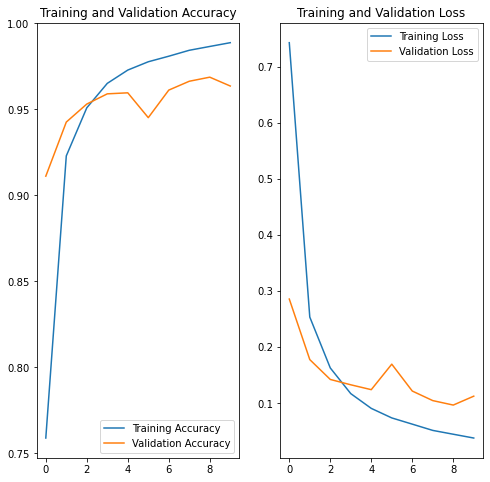

In [13]:
import matplotlib.pyplot as plt

acc = history_basic.history['accuracy']
val_acc = history_basic.history['val_accuracy']

loss = history_basic.history['loss']
val_loss = history_basic.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

- 기본 모델의 학습/검증 loss, accuracy를 시각화하였을 때, 0.05 정도의 차이가 발생한다. 
- 학습 데이터 뿐 아니라, 검증 데이터에서도 95% 이상의 높은 정확도를 갖는다.

### 5.2 Skip-Connection 모델

In [10]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

In [11]:
# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/spec_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [12]:
#30분 내외 소요
history_spec_skip = model_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/10
1422/1423 [============================>.] - ETA: 0s - loss: 0.8245 - accuracy: 0.7340
Epoch 00001: val_loss improved from inf to 0.32125, saving model to /home/aiffel-dj32/aiffel/speech_recognition/models/spec_skip
1423/1423 [==============================] - 66s 46ms/step - loss: 0.8241 - accuracy: 0.7341 - val_loss: 0.3212 - val_accuracy: 0.8950
Epoch 2/10
1423/1423 [==============================] - ETA: 0s - loss: 0.2778 - accuracy: 0.9143
Epoch 00002: val_loss improved from 0.32125 to 0.19724, saving model to /home/aiffel-dj32/aiffel/speech_recognition/models/spec_skip
1423/1423 [==============================] - 66s 47ms/step - loss: 0.2778 - accuracy: 0.9143 - val_loss: 0.1972 - val_accuracy: 0.9375
Epoch 3/10
1422/1423 [============================>.] - ETA: 0s - loss: 0.1778 - accuracy: 0.9472
Epoch 00003: val_loss improved from 0.19724 to 0.15730, saving model to /home/aiffel-dj32/aiffel/speech_recognition/models/spec_skip
1423/1423 [==============================

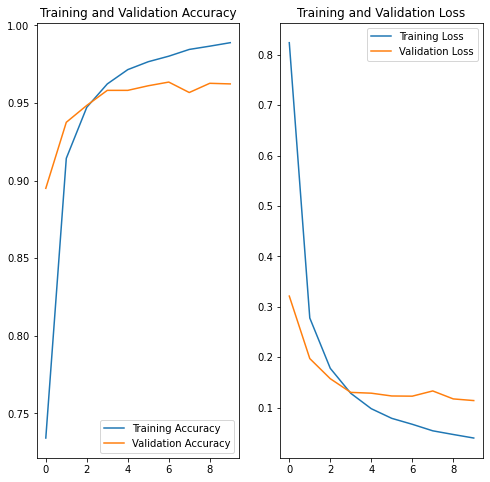

In [13]:
# 학습결과의 시각화 및 evaluation 과정
import matplotlib.pyplot as plt

acc = history_spec_skip.history['accuracy']
val_acc = history_spec_skip.history['val_accuracy']

loss = history_spec_skip.history['loss']
val_loss = history_spec_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

- Skip-connection 모델과 기본 모델에서 정확도, loss 차이가 크진 않지만, Epoch 7 부분에서 정확도, loss에서 조금의 차이가 있다.
    - 기본 모델에서 큰 변화가 있지만, skip-connection 모델에서는 변화폭이 낮다는 것을 볼 수 있다.
- 기본 모델과 마찬가지로 학습 데이터 뿐 아니라, 검증 데이터에서도 95% 이상의 높은 정확도를 갖는다.

## 6. Test dataset을 이용해 모델 성능 평가
### 6.1 기본 모델
- 저장한 Weight 불러오기

In [14]:
model_basic.load_weights(checkpoint_dir)

- 모델의 예측값과 정답값이 얼마나 일치하는지 확인

In [15]:
results = model_basic.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

159/159 [==============================] - 32s 204ms/step - loss: 0.0967 - accuracy: 0.9688
loss value: 0.097
accuracy value: 96.8787%
✅


- 혜림퍼실님이 슬랙에 올려주신 spec2wav 함수를 이용하여 두 학습 모델(기본, skip-connection)을 통해 예측한 음성을 출력했다. 출력 음성의 질이 떨어지나 복원을 성공적으로 마쳤다. 음성과 함께 나온 라벨과 실제 라벨 값의 비교에서도 예측값과 같은 값을 도출했다.
- 아래는 실제 테스트 라벨값과 예측값을 하나씩 뽑아 일치하는지 알아보기 위한 코드이다.
- 설명
    - `def spec2wav(wav)` : spectrogram으로 변환했던 파일을 다시 waveform 타입으로 변환해주는 함수
    - `batch_index` : 테스트 데이터 중 하나를 랜덤으로 뽑기 위한 랜덤 인덱스
    - `np.argmax(y_pred_)` : 예측한 라벨값, `batch_ys[0]` : 실제 테스트 라벨값(정답) 을 비교하여 체크한다.

In [17]:
def spec2wav(wav):
    D = np.abs(librosa.istft(wav))
    return D

import IPython.display as ipd
import random

# test data set 음성 비교
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_spec), size=1, replace=False)

batch_xs = test_spec[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_basic(batch_xs, training=False)

batch_xs_re = batch_xs.reshape(130, 126)
batch_wav = spec2wav(batch_xs_re)

y_pred_re = batch_xs.reshape(130, 126)
pred_wav = spec2wav(y_pred_re)

print("label :", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_wav.reshape(8000,), rate=8000)

label : right


In [19]:
# 테스트셋 라벨과 모델 실제 예측결과 비교
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + ' (Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + ' (Incorrect!)')
print("✅")

y_pred: right (Correct!)
✅


### 6.2 Skip-Connection 모델

In [14]:
# Evaluation 

# 저장한 weight
model_skip.load_weights(checkpoint_dir)
results = model_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

159/159 [==============================] - 32s 200ms/step - loss: 0.1138 - accuracy: 0.9623
loss value: 0.114
accuracy value: 96.2268%


In [37]:
import IPython.display as ipd
import random

# test data set 음성 비교
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_spec), size=1, replace=False)

batch_xs = test_spec[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_skip(batch_xs, training=False)

batch_xs_re = batch_xs.reshape(130, 126)
batch_wav = spec2wav(batch_xs_re)

y_pred_re = batch_xs.reshape(130, 126)
pred_wav = spec2wav(y_pred_re)

print("label :", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_wav.reshape(8000,), rate=8000)

label : stop


In [38]:
# 테스트셋 라벨과 모델 실제 예측결과 비교
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + ' (Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + ' (Incorrect!)')
print("✅")

y_pred: stop (Correct!)
✅


---
# 루비닉
## 1. 음성데이터를 2차원 Spectrogram 으로 변환하여 데이터셋을 구성하였다.
- 스펙트로그램 시각화 및 train/test 데이터셋 구성이 정상진행되었다.
- 스펙트로그램 데이터 중 두 데이터를 가져와 시각화하고, wav 데이터를 변환한 스펙트로그램 데이터(spec_data)를 이용해 train/test 데이터를 나누고, `tf.data.Dataset.from_tensor_slices() 함수, 원 핫 인코딩, train_dataset.repeat().batch()`를 통해 데이터셋을 구성하였다.
```
train_dataset = tf.data.Dataset.from_tensor_slices((train_spec, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
```

## 2. 1, 2차원 데이터를 처리하는 음성인식 모델이 정상 작동한다.
- 스펙트로그램을 입력받은 모델이 학습과정에서 안정적으로 수렴하며, evaluation/test 단계를 무리없이 진행가능하다.
- 스펙트로그램을 입력받은 기본 모델과 skip-connectioin 모델은 학습과정에서 약 95%으로 수렴하였고, evaluation/test 단계에서 다시 음성으로 변환하였을 때, 그리고 모델을 통해 예측한 라벨값은 테스트 데이터 라벨값과 같게 출력되었다.

## 3. 테스트셋 수행결과 음성인식 모델의 Accuracy가 일정 수준에 도달하였다.
- evaluation 결과 75% 이상의 정확도를 달성하는 모델이 하나 이상 존재한다.
- 기본 모델과 skip-connection 모델의 평가 결과 약 95% 이상의 정확도를 달성하였다.

---
# 마무리
2021 01 28 THUR
- spectrogram 변환 과정, 데이터셋 구성에서 커널이 죽는 현상이 계속 일어났다. 거기다 이해하는데 시간이 걸렸고, spectrogram 타입의 데이터 관련 자료가 많지 않아 다른 노드에 비해 많이 어렵게 느껴졌다. 하지만! 구글보다도 **슬랙과 조원분들의 도움**을 정말 많이 받았다. 짱짱//